In [1]:
import json
import tempfile
from copy import copy
from io import StringIO
import numpy as np
from Bio import SeqIO, AlignIO, codonalign
from Bio.Align.Applications import MuscleCommandline

/home/ricedap/repos/workshop-mol-evol-datasets/env-dev/lib/python3.9/site-packages/Bio/codonalign/__init__.py:23: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(


In [2]:
import re
import io
from itertools import groupby
from zipfile import ZipFile

## Introduction

"Big data era", getting data is a challenge.
NCBI datasets making it easier to get data for addressing a question.
Here's a specific example of a problem that can be addressed with big data:

Bio problem:
- **Our question**: can we detect natural selection by comparing ortholog sequences between species?
- Review: the redundant genetic code, synonymous and non-synonymous substitutions (Not frameshift indels)
- The molecular clock: synonymous mutations accumulate at a constant rate [FIGURE]
- Purifying selection: most non-synonymous mutations are harmful and eliminated by natural selection [FIGURE]
- Positive selection: some non-synonymous mutations may improve fitness. These will fix at a faster-than-neutral rate [FIGURE]
- **Idea**: we can compare the rates of syn/non-syn substitutions to look for signals of purifying or positive selection

We will compute the **dN/dS ratio**, that is the ratio of non-synonymous to synonymous substitutions.
- Low dN/dS indicates strong purifying selection (meaning the gene is important and well-adapted).
- Intermediate -> relaxed purifying selection.
- High -> strong positive selection, rapid adaptation
[DIAGRAM]

We will be comparing Drosophila species [PHYLOGENY] with different levels of divergence across a large number of ortholog families to categorize the orthologs by dN/dS.

## Getting the data

In [3]:
datadir = "/net/intdev/baby/scratch/mirian/workshops/ncbi_0722/orthologs_with_cds"

In [ ]:
!tree $datadir

# Using NCBI Datasets and jq to extract a list of gene IDs.


## Get a list of gene-ids using NCBI datasets and jq:

D. melanogaster (taxid: 7227)

```
datasets summary gene taxon 7227 --as-json-lines | jq -r '.gene.gene_id' > dmel_gene-ids.txt
Total number of gene IDs: 17,868
```

## Use the list of gene-ids as input to download all available ortholog sets:

Command with log file
```
time cat dmel_gene-ids.txt | while read GENEID; do 
	echo ${GENEID} $>> dmel_ortholog.log; 
	datasets download ortholog gene-id "${GENEID}" 
	--filename ./orthologs/$GENEID.zip 
	--taxon-filter 7215 --no-progressbar &>> dmel_ortholog.log; done
```	
	
Simplified command:
```
cat dmel_gene-ids.txt | while read GENEID; do 
	echo ${GENEID}; 
	datasets download ortholog gene-id "${GENEID}" 
	--filename ./orthologs/$GENEID.zip 
	--taxon-filter 7215; done
```

Explanation:
- Loop over each line of the gene-id list
- Download an ortholog set for each gene-id only for the genus Drosophila (`--taxon-filter 7215)

## From the log file, extract all the lines with the gene-ids (starting with numbers) and the following line.
`grep -A1 "^[0-9]" dmel_ortholog.log > dmel_summary.txt`

It looks like this:
```
10178776 $
Error: no valid NCBI gene identifiers, exiting
--
10178777 $
Found 14 genes in set
--
10178779 $
Error: no valid NCBI gene identifiers, exiting
--
```


## Extract the ortholog set-id and the species in each set from the Dmel list of genes:

```
datasets summary ortholog gene-id --inputfile dmel_gene-ids.txt --taxon-filter 7215 |  jq -r '[(.ortholog_set_id|tostring),.genes.genes[].gene.taxname] | @csv' > drosophila_setid_species.csv
```

## Get number of species per seq-id
```
cat drosophila_setid_species.csv | awk -F',' '{print $1,'\t', NF-1}' | sed 's/"//g' > drosophila_seqid_count.tsv
```

## Get number of ortholog sets per species
```
cat drosophila_setid_species.csv | cut -d',' -f2- | sed 's/,/\n/g' | sort | uniq -c | sort -r > drosphila_count_by_species.txt
```

In [ ]:
!head $datadir/drosophila_setid_species.csv

In [ ]:
!head $datadir/drosophila_seqid_count.tsv

In [ ]:
!sort -k2 -nr $datadir/drosophila_seqid_count.tsv

In [ ]:
!head $datadir/drosophila_count_by_species.txt

In [ ]:
ls $datadir/orthologs/

In [ ]:
!unzip -l $datadir/10178777.zip

## Computing dN/dS from sequences

We'll pick a gene and then read its FASTA and data report files into variables:

In [ ]:
# geneid = 7354476
#geneid = 59164
geneid = 32122
dataset = f"{datadir}/{geneid}.zip"

# Warning: "!" is iPython magic for running a bash command.
# The next two lines will not work outside of a Jupyter notebook
fasta = !unzip -p $dataset ncbi_dataset/data/rna.fna
data_report = !unzip -p $dataset ncbi_dataset/data/data_report.jsonl

In [ ]:
# geneid = 7354476
#geneid = 59164
geneid = 12798080
dataset = f"{datadir}/{geneid}.zip"

# Warning: "!" is iPython magic for running a bash command.
# The next two lines will not work outside of a Jupyter notebook
fasta = !unzip -p $dataset ncbi_dataset/data/cds.fna
data_report = !unzip -p $dataset ncbi_dataset/data/data_report.jsonl

In [ ]:
!unzip -p $dataset ncbi_dataset/data/data_table.tsv

In [ ]:
data_report

We read the fasta files using BioPython's SeqIO module:

In [13]:
def import_fasta(gene_id, datadir):
    dataset = f"{datadir}/{gene_id}.zip"
    fasta_path = "ncbi_dataset/data/cds.fna"
    with ZipFile(dataset) as zip_file:
        with zip_file.open(fasta_path, "r") as fasta_file:
            records = list(SeqIO.parse(io.TextIOWrapper(fasta_file), "fasta"))
    return(records)

In [16]:
gene_id = 12798080
records = import_fasta(gene_id, datadir)

NameError: name 'io' is not defined

In [ ]:
with StringIO("\n".join(fasta)) as f:
    records = list(SeqIO.parse(f, "fasta"))
for record in records:
    print(record)

In [16]:
def get_species(record):
    pattern = re.compile(r"\[organism=([A-Za-z\s]+)\]")
    match = re.search(pattern, record.description)
    if match:
        return match.groups()[0]
    else:
        return None

In [ ]:
for record in records:
    print(get_species(record))

In [30]:
def longest_record_per_species(records):
    return {
        species: max(recs, key=lambda r: len(r.seq))
        for species, recs in groupby(records, key=get_species)
    }


In [ ]:
dna_records = longest_record_per_species(records)

In [31]:
def translate_record(record):
    new_record = copy(record)
    new_record.seq = record.seq.translate()
    return new_record

In [ ]:
protein_records = {spec: translate_record(rec)} for spec, rec in dna_records.items()}

In [ ]:
print(protein_records)

In [8]:
def align_proteins(protein_records):
    muscle_exe = "muscle"
    with tempfile.NamedTemporaryFile(mode="w+t") as f:
        SeqIO.write([rec for _, rec in protein_records.values()], f, "fasta")
        f.seek(0)
        muscle_cline = MuscleCommandline(muscle_exe, input=f.name)
        stdout, stderr = muscle_cline()
    protein_aln = AlignIO.read(StringIO(stdout), "fasta")
    protein_aln.sort()
    return(protein_aln)

In [ ]:
protein_aln = align_proteins(protein_records)
print(protein_aln)

In [ ]:
codon_aln = codonalign.build(protein_aln, sorted([rec for (_, rec) in dna_records], key=lambda x: x.id))

In [ ]:
print(codon_aln)

In [9]:
def number_of_substitutions(alignment) -> float:
    sub_matrix = alignment.substitutions
    return sub_matrix.sum() - sub_matrix.diagonal().sum()

In [ ]:
total_subs = number_of_substitutions(codon_aln)
nonsyn_subs = number_of_substitutions(protein_aln)
syn_subs = total_subs - nonsyn_subs
dnds = nonsyn_subs / syn_subs

In [ ]:
print(total_subs)
print(nonsyn_subs)
print(syn_subs)
print(dnds)

In [15]:
def get_all_species(gene_id, datadir):
    records = import_fasta(gene_id, datadir)
    dna_records = longest_record_per_species(records)
    return set([s for s, _ in dna_records])

In [20]:
count_substitutions(12798080, datadir)

(31270.0, 12007.0)

In [17]:
files = !ls {datadir}
species = {}
for i, f in enumerate(files):
    gene_id = f.split(".")[0]
    print(i, gene_id)
    species[gene_id] = get_all_species(gene_id, datadir)
    print(species[gene_id])

0 10178777
{'Drosophila biarmipes', 'Drosophila santomea', 'Drosophila simulans', 'Drosophila eugracilis', 'Drosophila takahashii', 'Drosophila yakuba', 'Drosophila suzukii', 'Drosophila melanogaster', 'Drosophila rhopaloa', 'Drosophila erecta', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila mauritiana', 'Drosophila elegans'}
1 10178781
{'Drosophila biarmipes', 'Drosophila guanche', 'Drosophila santomea', 'Drosophila eugracilis', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila takahashii', 'Drosophila serrata', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila melanogaster', 'Drosophila kikkawai', 'Drosophila ficusphila', 'Drosophila erecta', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila mauritiana', 'Drosophila elegans'}
2 10178782
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans

{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila pseudoobscura', 'Drosophila kikkawai', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila hydei', 'Drosophila teissieri', 'Drosophila santomea'}
75 10178933
{'Drosophila santomea', 'Drosophila simulans', 'Drosophila takahashii', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila melanogaster', 'Drosophila ficusphila', 'Drosophila

{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila kikkawai', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila ananassae', 'Drosophila ficusphila', 'Drosophila teissieri', 'Drosophila santomea'}
132 117473
{'Drosophila biarmipes', 'Drosophila santomea', 'Drosophila simulans', 'Drosophila eugracilis', 'Drosophila takahashii', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila melanogaster', 'Drosophila erecta', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila mauritiana'}
133 117475
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura',

{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila ficusphila', 'Drosophila hydei', 'Drosophila teissieri', 'Drosophila santomea', 'Drosophila grimshawi'}
152 12797860
{'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila yakuba', 'Drosophila mauritiana', 'Drosophila elegans', 'Drosophila simu

{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila sechellia', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila teissieri', 'Drosophila santomea', 'Drosophila grimshawi'}
173 12797926
{'Drosophila simulans', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila melanogaster', 'Drosophila bipectinata', 'Drosophila ananassae', 'Drosophila ficusphila', 'Drosophila erecta', 'Drosophila sechellia', 'Dr

{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila hydei', 'Drosophila santomea', 'Drosophila grimshawi'}
221 12798198
{'Drosophila santomea', 'Drosophila simulans', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila m

{'Drosophila biarmipes', 'Drosophila santomea', 'Drosophila simulans', 'Drosophila takahashii', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila rhopaloa', 'Drosophila melanogaster', 'Drosophila erecta', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila mauritiana', 'Drosophila elegans'}
257 12798328
{'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila teissieri', 'Drosophila santomea'}
258 12798329
{'Drosophila rhopaloa', 'Drosophila yakuba', 'Drosophila m

{'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila yakuba', 'Drosophila mauritiana', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila sechellia', 'Drosophila biarmipes', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila teissieri', 'Drosophila santomea'}
304 12798465
{'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila yakuba', 'Drosophila mauritiana', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila serrata', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila biarmipes', 'Drosophila miranda', 'Drosophila teissieri', 'Drosophila santomea'}
305 12798466
{'Drosophila bia

{'Drosophila takahashii', 'Drosophila yakuba', 'Drosophila willistoni', 'Drosophila suzukii', 'Drosophila melanogaster', 'Drosophila bipectinata', 'Drosophila novamexicana', 'Drosophila ficusphila', 'Drosophila ananassae', 'Drosophila erecta', 'Drosophila santomea', 'Drosophila elegans'}
357 14462485
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophi

{'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila hydei', 'Drosophila teissieri', 'Drosophila santomea'}
400 14462751
{'Drosophila biarmipes', 'Drosophila santomea', 'Drosophila simulans', 'Drosophila eugracilis', 'Drosophila takahashii', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophi

{'Drosophila guanche', 'Drosophila arizonae', 'Drosophila yakuba', 'Drosophila mauritiana', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila miranda', 'Drosophila bipectinata', 'Drosophila teissieri', 'Drosophila santomea'}
438 192481
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila pseudoobscura', 'Drosophila kikkawai', 'Drosophila sechellia', 'Drosophila b

{'Drosophila biarmipes', 'Drosophila santomea', 'Drosophila simulans', 'Drosophila eugracilis', 'Drosophila takahashii', 'Drosophila serrata', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila rhopaloa', 'Drosophila melanogaster', 'Drosophila kikkawai', 'Drosophila ficusphila', 'Drosophila erecta', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila mauritiana', 'Drosophila elegans'}
455 19834823
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila yakuba', 'Drosophila mauritiana', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila kikkawai', 'Drosophila sechellia', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila teissieri', 'Drosophila santomea'}
456 19834824
{'Drosophila guanche'

{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila arizonae', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila pseudoobscura', 'Drosophila mojavensis', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila hydei', 'Drosophila grimshawi'}
490 19835398
{'Drosophila santomea', 'Drosophila simulans', 'Drosophila eugracilis', 'Drosophila takahashii', 'Drosophila serrata', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila miranda', 'Drosophila rhopaloa', 'Drosophila suzukii', 'Drosophila melanogaster', 'Drosophila ficusphila', 'Drosophila erecta', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila mauritiana', 'Drosophila elegans'}
491 19835431
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila rhopa

{'Drosophila innubila', 'Drosophila persimilis', 'Drosophila navojoa', 'Drosophila willistoni', 'Drosophila virilis', 'Drosophila miranda', 'Drosophila suzukii', 'Drosophila novamexicana', 'Drosophila melanogaster', 'Drosophila pseudoobscura', 'Drosophila hydei', 'Drosophila arizonae', 'Drosophila mojavensis', 'Drosophila grimshawi'}
522 19835868
{'Drosophila santomea', 'Drosophila simulans', 'Drosophila eugracilis', 'Drosophila takahashii', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila rhopaloa', 'Drosophila bipectinata', 'Drosophila melanogaster', 'Drosophila erecta', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila mauritiana'}
523 19835876
{'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila simulans', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila takahashi

{'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila pseudoobscura', 'Drosophila kikkawai', 'Drosophila sechellia', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila teissieri', 'Drosophila santomea'}
576 246416
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila yakuba', 'Drosophila mauritiana', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila serrata', 'Drosophila erecta', 'Drosophila persimilis', 'Drosophila melanogaster', 'Drosophila pseudoobscura', 'Drosophila kikkawai', 'Drosophila

{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila hydei', 'Drosophila teissieri', 'Drosophila santomea', 'Drosophila grimshawi'}
625 246496
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila a

{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila hydei', 'Drosophila teissieri', 'Drosophila santomea', 'Drosophila grimshawi'}
644 246523
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila a

{'Drosophila biarmipes', 'Drosophila santomea', 'Drosophila simulans', 'Drosophila eugracilis', 'Drosophila takahashii', 'Drosophila serrata', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila melanogaster', 'Drosophila ananassae', 'Drosophila kikkawai', 'Drosophila ficusphila', 'Drosophila erecta', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila mauritiana', 'Drosophila elegans'}
661 246548
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophil

{'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila yakuba', 'Drosophila mauritiana', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila pseudoobscura', 'Drosophila kikkawai', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila ficusphila', 'Drosophila teissieri', 'Drosophila santomea'}
675 246568
{'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila yakuba', 'Drosophila mauritiana', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila serrata', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila kikkawai', 'Drosophila sechellia', 'Drosophila biarmipes', 'Drosophila ananassae', 'Drosophil

{'Drosophila eugracilis', 'Drosophila rhopaloa', 'Drosophila yakuba', 'Drosophila mauritiana', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila serrata', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila kikkawai', 'Drosophila sechellia', 'Drosophila biarmipes', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila teissieri', 'Drosophila santomea'}
708 246611
{'Drosophila biarmipes', 'Drosophila santomea', 'Drosophila simulans', 'Drosophila eugracilis', 'Drosophila takahashii', 'Drosophila yakuba', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila rhopaloa', 'Drosophila melanogaster', 'Drosophila ficusphila', 'Drosophila erecta', 'Drosophila sechellia', 'Drosophila teissieri', 'Drosophila mauritiana', 'Drosophila elegans'}
709 246614
{'Drosophila guanche', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana'

{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila hydei', 'Drosophila teissieri', 'Drosophila santomea', 'Drosophila grimshawi'}
749 250710
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila 

{'Drosophila guanche', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila persimilis', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila hydei', 'Drosophila teissieri', 'Drosophila santomea', 'Drosophila grimshawi'}
777 26067050
{'Drosophila guanche', 'Drosophila albomicans', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila virilis', 'Drosophila subpulchrel

{'Drosophila melanogaster', 'Drosophila erecta'}
795 26067077
{'Drosophila guanche', 'Drosophila eugracilis', 'Drosophila albomicans', 'Drosophila rhopaloa', 'Drosophila arizonae', 'Drosophila mauritiana', 'Drosophila yakuba', 'Drosophila elegans', 'Drosophila simulans', 'Drosophila subobscura', 'Drosophila serrata', 'Drosophila virilis', 'Drosophila subpulchrella', 'Drosophila suzukii', 'Drosophila erecta', 'Drosophila innubila', 'Drosophila navojoa', 'Drosophila persimilis', 'Drosophila takahashii', 'Drosophila melanogaster', 'Drosophila novamexicana', 'Drosophila kikkawai', 'Drosophila pseudoobscura', 'Drosophila sechellia', 'Drosophila busckii', 'Drosophila mojavensis', 'Drosophila biarmipes', 'Drosophila obscura', 'Drosophila willistoni', 'Drosophila miranda', 'Drosophila ananassae', 'Drosophila bipectinata', 'Drosophila ficusphila', 'Drosophila hydei', 'Drosophila teissieri', 'Drosophila santomea', 'Drosophila grimshawi'}
796 26067078
{'Drosophila persimilis', 'Drosophila navojoa

In [27]:
from collections import Counter

In [28]:
species_counts = Counter()
for gid, sp_set in species.items():
    for sp in sp_set:
        species_counts[sp] += 1

In [29]:
print(species_counts)

Counter({'Drosophila melanogaster': 797, 'Drosophila simulans': 707, 'Drosophila mauritiana': 702, 'Drosophila sechellia': 696, 'Drosophila yakuba': 677, 'Drosophila teissieri': 665, 'Drosophila santomea': 664, 'Drosophila erecta': 661, 'Drosophila suzukii': 596, 'Drosophila takahashii': 594, 'Drosophila subpulchrella': 587, 'Drosophila eugracilis': 575, 'Drosophila biarmipes': 572, 'Drosophila rhopaloa': 572, 'Drosophila elegans': 571, 'Drosophila ficusphila': 544, 'Drosophila ananassae': 453, 'Drosophila kikkawai': 427, 'Drosophila serrata': 424, 'Drosophila bipectinata': 411, 'Drosophila persimilis': 359, 'Drosophila pseudoobscura': 359, 'Drosophila obscura': 357, 'Drosophila guanche': 356, 'Drosophila subobscura': 355, 'Drosophila willistoni': 315, 'Drosophila miranda': 297, 'Drosophila virilis': 296, 'Drosophila mojavensis': 296, 'Drosophila navojoa': 288, 'Drosophila novamexicana': 287, 'Drosophila innubila': 285, 'Drosophila hydei': 285, 'Drosophila arizonae': 284, 'Drosophila b

In [45]:
def count_substitutions(gene_id, datadir, species1, species2):
    records = import_fasta(gene_id, datadir)
    longest_records = longest_record_per_species(records)
    if species1 in longest_records and species2 in longest_records:
        dna_records = {
            species1: longest_records[species1],
            species2: longest_records[species2],
        }
    else:
        return None
    protein_records = {spec: translate_record(rec) for spec, rec in dna_records.items()}
    protein_aln = align_proteins(protein_records)
    try:
        codon_aln = codonalign.build(protein_aln,
                                     sorted(dna_records.values(),
                                            key=lambda x: x.id))
    except RuntimeError as e:
        print(e)
        return None
    total_subs = number_of_substitutions(codon_aln)
    nonsyn_subs = number_of_substitutions(protein_aln)
    return total_subs, nonsyn_subs

In [60]:
substitutions = {}
focal_species = "Drosophila melanogaster"
comparison_species = ["Drosophila pseudoobscura", "Drosophila serrata", "Drosophila simulans"]
for comp in comparison_species:
    print(comp)
    substitutions[comp] = {}
    for i, f in enumerate(files):
        gene_id = f.split(".")[0]
        print(i, gene_id)
        subs = count_substitutions(gene_id, datadir, focal_species, comp)
        if subs:
            substitutions[comp][gene_id] = subs

Drosophila pseudoobscura
0 10178777
1 10178781
2 10178782
3 10178784
4 10178785
5 10178787
6 10178792
7 10178793
8 10178795
9 10178796
10 10178797
11 10178805
12 10178806
13 10178809
14 10178812
15 10178814
16 10178816
17 10178817
18 10178820
19 10178822
20 10178823
21 10178824
22 10178825
23 10178828
24 10178831
25 10178832
26 10178835
27 10178837
28 10178839
29 10178840
30 10178844
31 10178846
32 10178847
33 10178851
34 10178852
35 10178853
36 10178857
37 10178859
38 10178861
39 10178862
40 10178864
41 10178866
42 10178870
43 10178873
44 10178875
45 10178877
46 10178880
47 10178885
48 10178888
49 10178889
50 10178890
51 10178891
52 10178894
53 10178897
54 10178898
55 10178899
56 10178900
57 10178901
58 10178905
59 10178906
60 10178908
61 10178909
62 10178910
63 10178911
64 10178912
65 10178913
66 10178914
67 10178916
68 10178923
69 10178926
70 10178927
71 10178928
72 10178929
73 10178930
74 10178932
75 10178933
76 10178934
77 10178935
78 10178939
79 10178940
80 10178941
81 10178943
8

654 246535
655 246538
656 246539
657 246540
658 246541
659 246543
660 246545
661 246548
662 246549
663 246550
664 246551
665 246552
666 246553
667 246556
668 246560
669 246561
670 246562
671 246563
672 246565
673 246566
674 246567
675 246568
676 246569
677 246572
678 246573
679 246575
680 246576
681 246577
682 246578
683 246579
684 246580
685 246581
686 246582
687 246583
688 246584
689 246585
690 246587
691 246588
692 246589
693 246591
694 246593
695 246595
696 246596
697 246599
698 246600
699 246601
700 246602
701 246603
702 246604
703 246605
704 246606
705 246608
706 246609
707 246610
708 246611
709 246614
710 246616
711 246618
712 246620
713 246621
714 246624
715 246625
716 246627
717 246629
718 246630
719 246631
720 246633
721 246634
722 246638
723 246640
724 246644
725 246645
726 246646
727 246647
728 246648
729 246650
730 246651
731 246652
732 246653
733 246656
734 246659
735 246663
736 246666
737 246667
738 246668
739 246669
740 246670
741 246671
742 246672
743 246682
744 248102

517 19835749
518 19835750
519 19835787
520 19835861
521 19835865
522 19835868
523 19835876
524 19835885
525 19835887
526 19835889
527 19835902
528 19835907
529 19835957
530 19835998
531 19836003
532 19836004
533 19836008
534 19836027
535 19836032
536 19836034
537 19836048
538 19836050
539 19836061
540 19836082
541 19836089
542 19836101
543 19836116
544 19836117
545 19836138
546 19836171
547 19836175
548 19836177
549 19836181
550 19836188
551 19836197
552 19836220
553 19836228
554 19836231
555 19836240
556 19836250
Protein SeqRecord (NM_001298702.1:23-1514) and Nucleotide SeqRecord (NM_001298702.1:23-1514) do not match!
557 19836253
558 19988923
559 246383
560 246384
561 246386
562 246388
563 246389
564 246393
565 246395
566 246397
567 246399
568 246406
569 246408
570 246409
571 246411
572 246412
573 246413
574 246414
575 246415
576 246416
577 246417
578 246418
579 246419
580 246420
581 246422
582 246424
583 246425
584 246426
585 246428
586 246431
587 246432
588 246434
589 246435
590 24

/home/ricedap/repos/workshop-mol-evol-datasets/env-dev/lib/python3.9/site-packages/Bio/codonalign/__init__.py:628: BiopythonWarning: XM_016182744.3:133-375(D 75) does not correspond to XM_016182744.3:133-375(TAA)
  warnings.warn(
/home/ricedap/repos/workshop-mol-evol-datasets/env-dev/lib/python3.9/site-packages/Bio/codonalign/__init__.py:628: BiopythonWarning: XM_016182744.3:133-375(F 76) does not correspond to XM_016182744.3:133-375(GAC)
  warnings.warn(
/home/ricedap/repos/workshop-mol-evol-datasets/env-dev/lib/python3.9/site-packages/Bio/codonalign/__init__.py:628: BiopythonWarning: XM_016182744.3:133-375(S 77) does not correspond to XM_016182744.3:133-375(TTC)
  warnings.warn(
/home/ricedap/repos/workshop-mol-evol-datasets/env-dev/lib/python3.9/site-packages/Bio/codonalign/__init__.py:628: BiopythonWarning: XM_016182744.3:133-375(R 78) does not correspond to XM_016182744.3:133-375(TCG)
  warnings.warn(


259 12798330
260 12798331
261 12798334
262 12798338
263 12798339
264 12798340
265 12798341
266 12798343
267 12798347
268 12798348
269 12798350
270 12798363
271 12798364
272 12798365
273 12798367
274 12798369
275 12798372
276 12798379
277 12798381
278 12798394
279 12798395
280 12798403
281 12798405
282 12798406
283 12798407
284 12798408
285 12798413
286 12798414
287 12798419
288 12798420
289 12798422
290 12798425
291 12798428
292 12798436
293 12798437
294 12798438
295 12798442
296 12798445
297 12798449
298 12798450
299 12798457
300 12798458
301 12798459
302 12798460
303 12798461
304 12798465
305 12798466
306 12798467
307 12798468
308 12798476
309 12798477
310 12798498
311 12798510
312 12798514
313 12798515


/home/ricedap/repos/workshop-mol-evol-datasets/env-dev/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for NM_001260318.1:6-660
  warnings.warn(


Protein SeqRecord (NM_001260318.1:6-660) and Nucleotide SeqRecord (NM_001260318.1:6-660) do not match!
314 12798516
315 12798517
316 12798518
317 12798528
318 12798530
319 12798539
320 12798544
321 12798550
322 12798551
323 12798556
324 12798557
325 12798569
326 12798570
327 12798574
328 12798579
329 12798583
330 12798585
331 12798588
332 13084062
333 13084068
334 13084069
335 140439
336 14462401
337 14462405
338 14462410
339 14462411
340 14462434
341 14462437
342 14462442
343 14462445
344 14462452
345 14462454
346 14462455
347 14462463
348 14462464
349 14462470
350 14462474
351 14462475
352 14462476
353 14462479
354 14462482
355 14462483
356 14462484
357 14462485
358 14462486
359 14462489
360 14462512
361 14462523
362 14462537
363 14462556
364 14462557
365 14462577
366 14462585
367 14462588
368 14462591
369 14462596
370 14462597
371 14462605
372 14462611
373 14462612
374 14462613
375 14462614
376 14462615
377 14462616
378 14462617
379 14462620
380 14462622
381 14462623
382 14462625
38

/home/ricedap/repos/workshop-mol-evol-datasets/env-dev/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for NM_001272953.1:1-1163
  warnings.warn(


Protein SeqRecord (NM_001272953.1:1-1163) and Nucleotide SeqRecord (NM_001272953.1:1-1163) do not match!
386 14462673
387 14462674
388 14462678
389 14462685
390 14462687
391 14462692
392 14462693
393 14462699
394 14462701
395 14462712
396 14462714
397 14462726
398 14462740
399 14462750
400 14462751
401 14462757
402 14462759
403 14462761
404 14462762
405 14462774
406 14462776
407 14462777
408 14462778
409 14462783
410 14462793
411 14462795
412 14462799
413 14462830
414 14462836
415 14462837
416 14462838
417 14462840
418 14462843
419 14462845
420 14462850
421 14462851
422 14462860
423 14462861
424 14462862
425 14462875
426 14462878
427 14462879
428 14462886
429 14462897
430 14462900
431 14462901
432 14462910
433 14462915
434 170876
435 170878
436 170882
437 170887
438 192481
439 192506
440 192507
441 192508
442 192509
443 192528
444 192535
445 192611
446 19834718
447 19834720
448 19834721
449 19834757
450 19834760
451 19834761
452 19834768
453 19834795
454 19834814
455 19834823
456 19834

/home/ricedap/repos/workshop-mol-evol-datasets/env-dev/lib/python3.9/site-packages/Bio/codonalign/__init__.py:384: BiopythonWarning: middle frameshift detection failed for NM_001382132.1:26-296
  warnings.warn(


In [47]:
import matplotlib.pyplot as plt

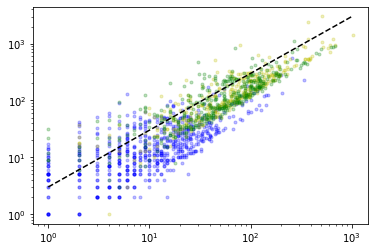

In [126]:
for total_subs, nonsyn_subs in substitutions["Drosophila simulans"].values():
    plt.loglog(nonsyn_subs, total_subs - nonsyn_subs, '.b', alpha=0.25)
    
for total_subs, nonsyn_subs in substitutions["Drosophila pseudoobscura"].values():
    plt.loglog(nonsyn_subs, total_subs - nonsyn_subs, '.y', alpha=0.25)
   
for total_subs, nonsyn_subs in substitutions["Drosophila serrata"].values():
    plt.loglog(nonsyn_subs, total_subs - nonsyn_subs, '.g', alpha=0.25)

plt.loglog([1, 1000], [3,3000], "--k")

In [ ]:
sorted(substitutions["Drosophila pseudoobscura"])

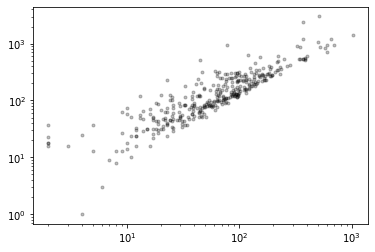

In [53]:
for total_subs, nonsyn_subs in substitutions.values():
    plt.loglog(nonsyn_subs, total_subs - nonsyn_subs, '.k', alpha=0.25)

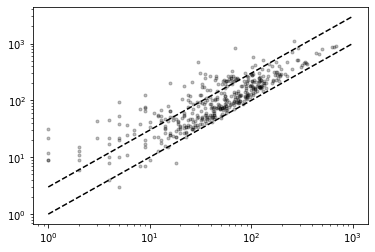

In [57]:
for total_subs, nonsyn_subs in substitutions.values():
    plt.loglog(nonsyn_subs, total_subs - nonsyn_subs, '.k', alpha=0.25)
plt.loglog([1, 1000], [2,2000], "--k")

Now we need to get the CDS ranges from the metadata file. Note that we're taking the longest CDS per species.

In [ ]:
cds_ranges = {}
for species in map(json.loads, data_report):
    cds_list = [(t["cds"]["accessionVersion"],
                 int(t["cds"]["range"][0]["begin"]),
                 int(t["cds"]["range"][0]["end"]))
                for t in species["transcripts"]]
    longest_cds = max(cds_list, key=lambda x: x[2] - x[1])
    cds_ranges[longest_cds[0]] = longest_cds[1:]
print(cds_ranges)

Check that we're indexing correctly:

In [ ]:
for record in records:
    if record.id in cds_ranges:
        start, end = cds_ranges[record.name]
        print(record.description)
        print(len(record.seq[start - 1:end]) % 3)

We need to make a codon alignment [workflow DIAGRAM]. To do this we'll create two sets of records:
- nucleiotide sequence records with just the coding sequences
- protein sequence records translated from the CDS

In [ ]:
cds_records = []
protein_records = []
for record in records:
    if record.id in cds_ranges:
        start, end = cds_ranges[record.name]
        cds_seq = record.seq[start - 1: end]
        cds_rec = copy(record)
        cds_rec.seq = cds_seq
        cds_records.append(cds_rec)
        
        protein_rec = copy(record)
        protein_rec.seq = cds_rec.seq.translate()
        protein_records.append(protein_rec)

TODO: Quality control for length, M, *

In [ ]:
print(protein_records)

Now we align the protein sequences:

In [ ]:
muscle_exe = "muscle"
with tempfile.NamedTemporaryFile(mode="w+t") as f:
    SeqIO.write(protein_records, f, "fasta")
    f.seek(0)
    muscle_cline = MuscleCommandline(muscle_exe, input=f.name)
    stdout, stderr = muscle_cline()
    protein_aln = AlignIO.read(StringIO(stdout), "fasta")
    protein_aln.sort()

In [ ]:
print(protein_aln)

We can combine the protein alignments with the CDS alignments to get a codon-aware alignment.

In [ ]:
codon_aln = codonalign.build(protein_aln, sorted(cds_records, key=lambda x: x.id))

In [ ]:
print(codon_aln)

Finally, we can look at the substitutions and count the number of synonymous and non-synonymous substitutions.

Small example (with diagram) of counting substitutions

## TO-DO:
- Repeat for different genes
- Plots of DN vs DS, where each point is a species comparison
- Scatterplot of DN vs DS, where each point is a gene
- The same, but highlighting a set of genes of interest

In [134]:
from Bio.Seq import Seq, MutableSeq
from itertools import product, combinations

In [101]:
bases = set(["A", "C", "G", "T"])
for comb in product(bases, repeat=3):
    s = Seq("".join(comb))
    print(s, "->", s.translate())

GGG -> G
GGT -> G
GGA -> G
GGC -> G
GTG -> V
GTT -> V
GTA -> V
GTC -> V
GAG -> E
GAT -> D
GAA -> E
GAC -> D
GCG -> A
GCT -> A
GCA -> A
GCC -> A
TGG -> W
TGT -> C
TGA -> *
TGC -> C
TTG -> L
TTT -> F
TTA -> L
TTC -> F
TAG -> *
TAT -> Y
TAA -> *
TAC -> Y
TCG -> S
TCT -> S
TCA -> S
TCC -> S
AGG -> R
AGT -> S
AGA -> R
AGC -> S
ATG -> M
ATT -> I
ATA -> I
ATC -> I
AAG -> K
AAT -> N
AAA -> K
AAC -> N
ACG -> T
ACT -> T
ACA -> T
ACC -> T
CGG -> R
CGT -> R
CGA -> R
CGC -> R
CTG -> L
CTT -> L
CTA -> L
CTC -> L
CAG -> Q
CAT -> H
CAA -> Q
CAC -> H
CCG -> P
CCT -> P
CCA -> P
CCC -> P


In [107]:
codons = (Seq("".join(b)) for b in product(bases, repeat=3))
genetic_code = {
    codon: codon.translate()
    for codon in codons
    if codon.translate() != Seq("*")
}

In [137]:
def count_differences(codon1, codon2):
    return sum(b1 != b2 for b1, b2 in zip(codon1, codon2))

nonsyn_counts = Counter()
syn_counts = Counter()
for codon1, codon2 in combinations(genetic_code, 2):
    if count_differences(codon1, codon2) == 1:
        if genetic_code[codon1] == genetic_code[codon2]:
            syn_counts[codon1] += 1
            syn_counts[codon2] += 1
        else:
            nonsyn_counts[codon1] += 1
            nonsyn_counts[codon2] += 1

In [138]:
for codon in genetic_code:
    print(codon, nonsyn_counts[codon], syn_counts[codon])

GGG 6 3
GGT 6 3
GGA 5 3
GGC 6 3
GTG 6 3
GTT 6 3
GTA 6 3
GTC 6 3
GAG 7 1
GAT 8 1
GAA 7 1
GAC 8 1
GCG 6 3
GCT 6 3
GCA 6 3
GCC 6 3
TGG 7 0
TGT 7 1
TGC 7 1
TTG 6 2
TTT 8 1
TTA 5 2
TTC 8 1
TAT 6 1
TAC 6 1
TCG 5 3
TCT 6 3
TCA 4 3
TCC 6 3
AGG 7 2
AGT 8 1
AGA 6 2
AGC 8 1
ATG 9 0
ATT 7 2
ATA 7 2
ATC 7 2
AAG 7 1
AAT 8 1
AAA 7 1
AAC 8 1
ACG 6 3
ACT 6 3
ACA 6 3
ACC 6 3
CGG 5 4
CGT 6 3
CGA 4 4
CGC 6 3
CTG 5 4
CTT 6 3
CTA 5 4
CTC 6 3
CAG 7 1
CAT 8 1
CAA 7 1
CAC 8 1
CCG 6 3
CCT 6 3
CCA 6 3
CCC 6 3


In [139]:
nonsyn_total = sum(nonsyn_counts.values())
syn_total = sum(syn_counts.values())
print(nonsyn_total / syn_total)

2.925373134328358


In [148]:
def expected_dnds(seq, nonsyn_counts, syn_counts):
    nonsyn = 0
    syn = 0
    for i in range(0, len(seq), 3):
        codon = seq[i:i+3]
        try:
            nonsyn += nonsyn_counts[codon]
            syn += syn_counts[codon]
        except KeyError:
            return None
    return nonsyn / syn

In [151]:
gene_ids = [f.split(".")[0] for f in files]
focal_species = "Drosophila melanogaster"
expectations = {}
for gene_id in gene_ids:
    records = import_fasta(gene_id, datadir)
    longest_records = longest_record_per_species(records)
    if focal_species not in longest_records:
        continue
    seq = longest_records[focal_species].seq
    expectations[gene_id] = expected_dnds(seq, nonsyn_counts, syn_counts)

(array([  7.,  22.,  96., 272., 249., 102.,  32.,  13.,   3.,   1.]),
 array([2.26655443, 2.52462121, 2.78268799, 3.04075477, 3.29882155,
        3.55688833, 3.81495511, 4.07302189, 4.33108866, 4.58915544,
        4.84722222]),
 <BarContainer object of 10 artists>)

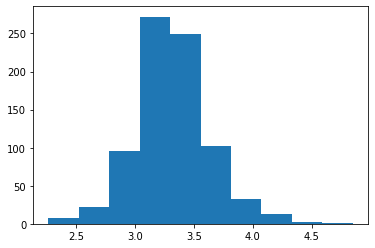

In [152]:
plt.hist(expectations.values())

In [156]:
omega = {}
for gene_id, (total_subs, nonsyn_subs) in substitutions["Drosophila pseudoobscura"].items():
    syn_subs = total_subs = nonsyn_subs
    dnds = nonsyn_subs / syn_subs
    expected_dnds = expectations[gene_id]
    omega[gene_id] = dnds / expected_dnds

/tmp/ipykernel_29512/2092835143.py:4: RuntimeWarning: invalid value encountered in double_scalars
  dnds = nonsyn_subs / syn_subs


In [ ]:
plt.hist(omega)

(array([36., 36., 36., 35., 36., 36., 35., 36., 36., 36.]),
 array([  0. ,  35.7,  71.4, 107.1, 142.8, 178.5, 214.2, 249.9, 285.6,
        321.3, 357. ]),
 <BarContainer object of 10 artists>)